#**Deep Learning with CIFAR Data**

In [1]:
#Import modules
from __future__ import print_function
import numpy as np
import tensorflow as tf
import cPickle
import matplotlib.pyplot as plt
import sys
import random
import os
import tarfile
import time
import scipy
import skimage
from skimage import filter as filters
from scipy import ndimage

/home/araman/anaconda2/envs/tensorflow/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Extract dataset from compressed .tar.gz file. 
This should give us a set of directories labeled data_batch_1.bin, data_batch_2.bin, ..., data_batch_5.bin, as well as test_batch.bin. 
Loaded in this way, each of the batch files contains a dictionary with the following elements: 
  1. data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. 
  2. labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [2]:
def extract(filename):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  print('Extracting data for %s. This may take a while. Please wait...' % root)
  tar = tarfile.open(filename)
  sys.stdout.flush()
  tar.extractall()
  tar.close()
  print('Finished extracting')  
    

extract('/home/araman/Downloads/cifar-10-python.tar.gz')

Extracting data for /home/araman/Downloads/cifar-10-python. This may take a while. Please wait...
Finished extracting


In [3]:
#Get a training set, validation set, and test set along with their labels


def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict


train_batch_1 = unpickle('/home/araman/PycharmProjects/CIFARLogisticRegression/cifar-10-batches-py/data_batch_1')
train_batch_2 = unpickle('/home/araman/PycharmProjects/CIFARLogisticRegression/cifar-10-batches-py/data_batch_2')
train_batch_3 = unpickle('/home/araman/PycharmProjects/CIFARLogisticRegression/cifar-10-batches-py/data_batch_3')
train_batch_4 = unpickle('/home/araman/PycharmProjects/CIFARLogisticRegression/cifar-10-batches-py/data_batch_4')
train_batch_data = np.vstack((train_batch_1['data'], train_batch_2['data'], train_batch_3['data'], train_batch_4['data']))

train_labels_1 = np.asarray(train_batch_1['labels'])
train_labels_2 = np.asarray(train_batch_2['labels'])
train_labels_3 = np.asarray(train_batch_3['labels'])
train_labels_4 = np.asarray(train_batch_4['labels'])
train_batch_labels = np.hstack((train_labels_1, train_labels_2, train_labels_3, train_labels_4))


validation_batch = unpickle('/home/araman/PycharmProjects/CIFARLogisticRegression/cifar-10-batches-py/data_batch_5')
test_batch = unpickle('/home/araman/PycharmProjects/CIFARLogisticRegression/cifar-10-batches-py/test_batch')
label_metadata = unpickle('/home/araman/PycharmProjects/CIFARLogisticRegression/cifar-10-batches-py/batches.meta')


train_data = train_batch_data
train_labels = train_batch_labels
validation_data = validation_batch['data']
validation_labels = np.asarray(validation_batch['labels'])
test_data = test_batch['data']
test_labels = np.asarray(test_batch['labels'])

print("Training batch data has dimensions {0}" .format(train_data.shape))
print('Validation batch data has dimensions {0}'.format(validation_data.shape))
print('Test batch data has dimensions {0}'  .format(test_data.shape))

print(train_labels.shape)

Training batch data has dimensions (40000, 3072)
Validation batch data has dimensions (10000, 3072)
Test batch data has dimensions (10000, 3072)
(40000,)


Let's display some images in our training data

40000
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


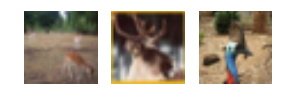

In [4]:
%matplotlib inline

def display_random_images(data, labels, sample_size):
    num_images = data.shape[0]
    print(num_images)
    data_reshaped = data.reshape(num_images, 3, 32, 32)
    random_nums = random.sample(range(num_images), sample_size)
    for i, num in enumerate(random_nums):
        img = data_reshaped[num, :, :, :]
        img = img.transpose(1,2,0)
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        #plt.title(label_metadata['label_names'][labels[num]])
        plt.imshow(img)
        print(img.shape)
    


sample_size = 3
display_random_images(train_data,train_labels, sample_size)

Reformat into a TensorFlow-friendly shape: convolutions need the image data formatted as a cube (width by height by #channels) labels as float 1-hot encodings.

Training set (40000, 32, 32, 3) (40000, 10)
Validation set (10000, 32, 32, 3) (10000, 10)
Test set (10000, 32, 32, 3) (10000, 10)


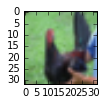

In [5]:
%matplotlib inline

image_size = 32
num_labels = 10
num_channels = 3 #RGB image

def reformat(dataset, labels):
    dataset = dataset.reshape(-1, num_channels, image_size, image_size).astype(np.float32)
    dataset = -dataset.transpose(0, 2,3,1)
    img = dataset[25, :,:,:]
    plt.subplot(2,4,1)
    plt.imshow(img)
    
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels



train_labels_not_one_hot = train_labels
train_data, train_labels = reformat(train_data, train_labels)
validation_data, validation_labels = reformat(validation_data, validation_labels)
test_data, test_labels = reformat(test_data, test_labels)

print('Training set', train_data.shape, train_labels.shape)
print('Validation set', validation_data.shape, validation_labels.shape)
print('Test set', test_data.shape, test_labels.shape)

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [9]:
batch_size = 128
patch_size_1 = 5
patch_size_2 = 5
patch_size_3 = 2

pool_stride_1 = 2
pool_stride_2 = 2
pool_stride_3 = 2

num_filters_1 = 32
num_filters_2 = 32
num_filters_3 = 64



num_hidden = 128
test_set_size = test_data.shape[0]

INITIAL_LEARNING_RATE = 0.1
LEARNING_RATE_DECAY_FACTOR = 0.1

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_data = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_validation_data = tf.constant(validation_data)
  tf_test_data = tf.constant(test_data)
  global_step = tf.Variable(0, trainable = False)
    
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size_1, patch_size_1, num_channels, num_filters_1], stddev=0.01))
  layer1_biases = tf.Variable(tf.zeros([num_filters_1]))

  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size_2, patch_size_2, num_filters_1, num_filters_2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[num_filters_2]))

  layer3_weights = tf.Variable(tf.truncated_normal(
      [patch_size_3, patch_size_3, num_filters_2, num_filters_3], stddev = 0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_filters_3]))

  layer4_weights = tf.Variable(tf.truncated_normal(
      [4*4*num_filters_3, num_hidden], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))

  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):   
        
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.avg_pool(conv, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    hidden = tf.nn.relu(pool + layer1_biases)
    
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.max_pool(conv, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    hidden = tf.nn.relu(pool + layer2_biases)
    
    conv = tf.nn.conv2d(hidden, layer3_weights, [1, 1, 1, 1], padding='VALID')
    pool = tf.nn.avg_pool(conv, ksize = [1,1,1,1], strides = [1,1,1,1], padding = 'VALID')
    hidden = tf.nn.relu(conv + layer3_biases)
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer4_weights) + layer4_biases)
    return tf.matmul(hidden, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_data)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  #learning_rate = tf.train.exponential_decay(0.00003, global_step, 5000, 0.5, staircase=True) 
  #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  optimizer = tf.train.GradientDescentOptimizer(0.00003).minimize(loss)
  
  
    
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  validation_prediction = tf.nn.softmax(model(tf_validation_data))
  test_prediction = tf.nn.softmax(model(tf_test_data))

In [16]:
start_time = time.time()
%matplotlib inline


num_steps = 1000000
final_test_prediction = np.zeros(test_set_size)

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    #batch_data = train_data[offset:(offset + batch_size), :, :, :]
    #batch_labels = train_labels[offset:(offset + batch_size), :]
    
    
    #Select a random batch of 128 images from the training set of 40,000 images
    #Generate 128*3 non repeating random numbers between [0 and 128*3)
    #Generate the rotated versions of each image (-90 and 90 degrees)
    #Place the normal and rotated images randomly into a another batch of size 128*3
    batch_elements = random.sample(range(40000), batch_size)
    batch_data = np.zeros(shape=(batch_size, image_size, image_size, num_channels))
    batch_labels = np.zeros(shape=(batch_size,10))
    batch_with_rotations = np.zeros(shape=(batch_size, image_size, image_size, num_channels))
    labels_with_rotations = np.zeros(shape=(batch_size,10))
    random_rotation_batch_elements = random.sample(range(0,batch_size), batch_size)
    
    
    
    #Fill up a batch of 128 images
    for i, elem in enumerate(batch_elements):
        batch_data[i,:,:,:] = train_data[elem, :, :, :]
        batch_labels[i,:] = train_labels[elem,:]
    
   
    
    #Fill up a bigger batch of the previous 128 images and their rotations
    counter = 0
    #for i in range(0,128):
    #    im = batch_data[i,:,:,:]
    #    im_rot90 = ndimage.interpolation.rotate(im, 90)
    #    im_rot_neg90 = ndimage.interpolation.rotate(im, -90)
    #    random_location_1 = random_rotation_batch_elements[counter]
    #    counter = counter+1
    #    random_location_2 = random_rotation_batch_elements[counter]
    #    counter = counter+1
    #    random_location_3 = random_rotation_batch_elements[counter]
    #    counter = counter+1
    #    batch_with_rotations[random_location_1, :, :, :] = im
    #    labels_with_rotations[random_location_1, :] = batch_labels[i, :]
    #    
    #    batch_with_rotations[random_location_2, :, :, :] = im_rot90
    #    labels_with_rotations[random_location_2, :] = batch_labels[i, :]
    #    
    #    batch_with_rotations[random_location_3, :, :, :] = im_rot_neg90
    #    labels_with_rotations[random_location_3, :] = batch_labels[i, :]

   
    #im = batch_with_rotations[6,:,:,:]
    #plt.subplot(2, 4, 1)
    #plt.imshow(im)
    #plt.show()
    #print(batch_with_rotations.shape)
        

    feed_dict = {tf_train_data : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step %  1000 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        validation_prediction.eval(), validation_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  final_test_prediction = test_prediction.eval()
  print(final_test_prediction.shape)
  print("--- %s seconds ---" % (time.time() - start_time))

Initialized
Minibatch loss at step 0: 65.681435
Minibatch accuracy: 10.2%
Validation accuracy: 9.2%
Minibatch loss at step 1000: 2.379875
Minibatch accuracy: 14.1%
Validation accuracy: 12.4%
Minibatch loss at step 2000: 2.372442
Minibatch accuracy: 15.6%
Validation accuracy: 14.8%
Minibatch loss at step 3000: 2.233000
Minibatch accuracy: 18.8%
Validation accuracy: 16.4%
Minibatch loss at step 4000: 2.234900
Minibatch accuracy: 16.4%
Validation accuracy: 18.3%
Minibatch loss at step 5000: 2.222034
Minibatch accuracy: 16.4%
Validation accuracy: 19.8%
Minibatch loss at step 6000: 2.262359
Minibatch accuracy: 23.4%
Validation accuracy: 20.9%
Minibatch loss at step 7000: 2.163549
Minibatch accuracy: 18.0%
Validation accuracy: 20.8%
Minibatch loss at step 8000: 2.186861
Minibatch accuracy: 24.2%
Validation accuracy: 22.2%
Minibatch loss at step 9000: 2.048158
Minibatch accuracy: 25.0%
Validation accuracy: 22.2%
Minibatch loss at step 10000: 2.037189
Minibatch accuracy: 24.2%
Validation accur

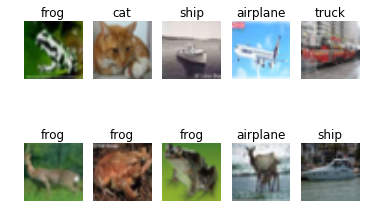

In [19]:
def display_results(data, one_hot_prediction, sample_size):
    data_size = data.shape[0]
    data_reshaped = data.reshape(data_size, 32, 32, 3)
    random_nums = random.sample(range(data_size),sample_size )
    for i, num in enumerate(random_nums):
        img = -data_reshaped[num, :, :, :]
        #img = img.reshape(3,32,32).transpose(1,2,0)
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        label_list = one_hot_prediction[num].tolist()
        max_value = max(label_list)
        label_num = label_list.index(max_value)
        plt.title(label_metadata['label_names'][label_num])
        plt.imshow(-1*img)

result_sample_size = 10    
display_results(test_data, final_test_prediction, result_sample_size)